# 03 — Fine-tuning + Evaluation

**Goal:** Improve baseline MAE by fine-tuning the last layers of ResNet50 with a small learning rate.

We:
- Load baseline checkpoint
- Unfreeze last N layers (keep BatchNorm frozen)
- Train with LR << stage1
- Evaluate on test
- Error analysis: MAE by age bins + worst predictions summary


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.config import load_config
from src.data import load_labels, validate_schema, make_splits, build_dataset
from src.model import build_resnet50_regressor, set_fine_tuning
from src.train import compile_model, make_finetune_callbacks, train_stage_2, save_test_metrics
from src.eval import predict_regression, mae_by_age_bins
from src.utils import plot_history_mae

PROJECT_ROOT = Path.cwd().parent
cfg = load_config(PROJECT_ROOT / "configs/default.yaml").raw

metrics_dir = PROJECT_ROOT / "reports" / "metrics"
fig_dir = PROJECT_ROOT / "reports" / "figures"
models_dir = PROJECT_ROOT / "models"

cfg


2026-01-20 19:58:59.711514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-20 19:58:59.856168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-20 19:59:02.261856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'project': {'name': 'age-prediction',
  'seed': 42,
  'device': 'gpu',
  'output_dir': 'reports'},
 'data': {'csv_path': 'data/labels.csv',
  'images_dir': 'data/images',
  'filename_col': 'file_name',
  'target_col': 'real_age',
  'image_size': [224, 224],
  'channels': 3,
  'batch_size': 32,
  'val_size': 0.15,
  'test_size': 0.15,
  'stratify_bins': 10,
  'cache': False,
  'prefetch': True},
 'model': {'backbone': 'ResNet50',
  'weights': 'imagenet',
  'pooling': 'avg',
  'dropout': 0.2,
  'dense_units': 128,
  'l2': 0.0},
 'train': {'epochs_stage1': 8,
  'epochs_stage2': 12,
  'lr_stage1': 0.001,
  'lr_stage2': 5e-05,
  'fine_tune_N_last': 30,
  'optimizer': 'adam',
  'loss': 'mae',
  'metrics': ['mae']},
 'callbacks': {'early_stopping_patience': 5,
  'reduce_lr_patience': 2,
  'reduce_lr_factor': 0.2,
  'min_lr': 1e-07},
 'artifacts': {'save_best': True,
  'best_model_path': 'models/best.keras',
  'history_path': 'reports/metrics/history.csv',
  'metrics_path': 'reports/metrics/t

In [2]:
# Load data
RANDOM_STATE = int(cfg['project']['seed'])
filename_col = cfg['data']['filename_col']
target_col = cfg['data']['target_col']

df = load_labels(PROJECT_ROOT / cfg['data']['csv_path'])
validate_schema(df, filename_col, target_col)
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# Recreate the same splits using the same seed
train_df, val_df, test_df = make_splits(
    df,
    filename_col=filename_col,
    target_col=target_col,
    val_size=float(cfg["data"]["val_size"]),
    test_size=float(cfg["data"]["test_size"]),
    seed=RANDOM_STATE,
    stratify_bins=int(cfg["data"]["stratify_bins"]),
)


In [4]:
# Build the Datasets

images_dir = PROJECT_ROOT / cfg["data"]["images_dir"]
image_size = tuple(cfg["data"]["image_size"])
batch_size = int(cfg["data"]["batch_size"])

train_ds = build_dataset(
    train_df,
    images_dir=images_dir,
    filename_col=filename_col,
    target_col=target_col,
    img_size=image_size,
    batch_size=batch_size,
    training=True,
    seed=RANDOM_STATE,
    cache=bool(cfg["data"].get("cache", False)),
    prefetch=bool(cfg["data"].get("prefetch", True)),
)

val_ds = build_dataset(
    val_df,
    images_dir=images_dir,
    filename_col=filename_col,
    target_col=target_col,
    img_size=image_size,
    batch_size=batch_size,
    training=False,
    seed=RANDOM_STATE,
    cache=bool(cfg["data"].get("cache", False)),
    prefetch=bool(cfg["data"].get("prefetch", True)),
)

test_ds = build_dataset(
    test_df,
    images_dir=images_dir,
    filename_col=filename_col,
    target_col=target_col,
    img_size=image_size,
    batch_size=batch_size,
    training=False,
    seed=RANDOM_STATE,
    cache=False,
    prefetch=True,
)


I0000 00:00:1768960742.103808   12214 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9704 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Fine-tuning setup

- Unfreeze last **N** layers of backbone
- Keep BatchNorm frozen
- Use small learning rate (e.g., 1e-5 to 3e-5)


In [ ]:
# Load the best baseline checkpoint (feature_extraction)
baseline_path = models_dir / 'baseline_best.keras'
model = tf.keras.models.load_model(baseline_path)

fine_tune_n_last = int(cfg['train']['fine_tune_N_last'])

set_fine_tuning(
    model, backbone_name='resnet50',
    fine_tune_n_last=fine_tune_n_last,
    freeze_batchnorm=True,
)

# sanity
model.summary()


Model: "resnet50_age_regressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,374,917 (92.98 MB)

 Trainable params: 14,691,073 (56.04 MB)

 Non-trainable params: 9,159,040 (34.94 MB)

 Optimizer params: 524,804 (2.00 MB)

Total layers in backbone: 6
Trainable layers in backbone: 6


In [11]:
# Sanity check 
backbone = model.get_layer("resnet50")
trainable_layers = [l.name for l in backbone.layers if l.trainable]
print(len(trainable_layers), trainable_layers[:5], trainable_layers[-5:])

# Is batchnorm frozen?
bn_trainable = [
    l.name for l in model.get_layer("resnet50").layers
    if isinstance(l, tf.keras.layers.BatchNormalization) and l.trainable
]
len(bn_trainable)


21 ['conv5_block1_2_conv', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_add'] ['conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_add', 'conv5_block3_out', 'avg_pool']


0

In [12]:
# Compile the model
lr_stage2 = cfg['train']['lr_stage2']
compile_model(model,lr=lr_stage2)

In [13]:
# Train fine tuning
epochs_stage2 = cfg['train']['epochs_stage2']

callbacks = make_finetune_callbacks(models_dir=models_dir, metrics_dir=metrics_dir,
                                    monitor="val_mae")

history_ft = train_stage_2(
    model, 
    train_ds,
    val_ds,
    epochs=epochs_stage2,
    callbacks=callbacks,
)

Epoch 1/12


2026-01-20 20:14:44.336956: I external/local_xla/xla/service/service.cc:163] XLA service 0x72b6c8004540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-20 20:14:44.337037: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-01-20 20:14:44.638656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-20 20:14:47.758260: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800
2026-01-20 20:14:48.283471: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-20 20:14:49.967390: I e

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 9.1432 - mae: 9.1432
Epoch 1: val_mae improved from None to 8.10354, saving model to /home/carlos/projects/age-estimation-resnet50/models/finetune_best.keras

Epoch 1: finished saving model to /home/carlos/projects/age-estimation-resnet50/models/finetune_best.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - loss: 8.7728 - mae: 8.7728 - val_loss: 8.1035 - val_mae: 8.1035 - learning_rate: 5.0000e-05
Epoch 2/12
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 7.6157 - mae: 7.6157
Epoch 2: val_mae did not improve from 8.10354
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 7.5290 - mae: 7.5290 - val_loss: 10.4660 - val_mae: 10.4660 - learning_rate: 5.0000e-05
Epoch 3/12
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 6.6519 - mae: 6.6519
Epoch 3: val_mae improved from 8.10354 to 7.98934, saving model to /home/carlos/projects/age-estimation-resnet50/models/finetune_best.keras

Epoch 3: finished saving model to /home/carlos/projects

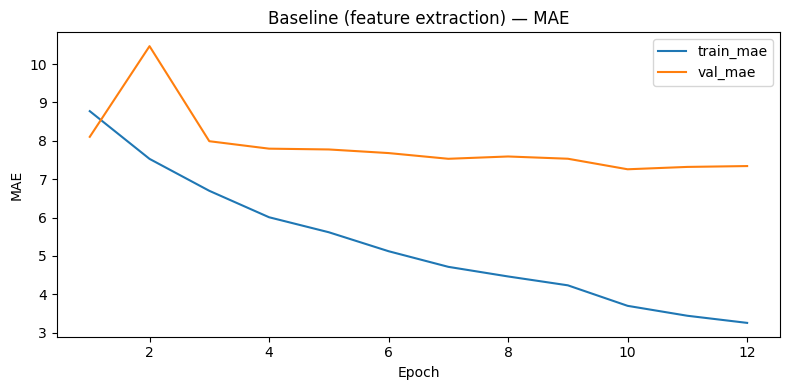

In [14]:
# Save MAE curve
fig_dir.mkdir(parents=True, exist_ok=True)
plot_history_mae(history_ft, fig_dir / "finetune_mae_curve.png")


In [15]:
# Save metrics 
test_loss, test_mae = model.evaluate(test_ds, verbose=0)
print("Fine-tuned Test MAE:", test_mae)

metrics = {
    "stage": "finetune",
    "test_mae": float(test_mae),
    "image_size": list(image_size),
    "batch_size": int(batch_size),
    "lr_stage2": float(lr_stage2),
    "epochs_stage2": int(epochs_stage2),
    "fine_tune_n_last": int(fine_tune_n_last),
    "seed": int(RANDOM_STATE),
}
save_test_metrics(metrics, metrics_dir / "finetune_test_metrics.json")
metrics


Fine-tuned Test MAE: 7.064752101898193


{'stage': 'finetune',
 'test_mae': 7.064752101898193,
 'image_size': [224, 224],
 'batch_size': 32,
 'lr_stage2': 5e-05,
 'epochs_stage2': 12,
 'fine_tune_n_last': 30,
 'seed': 42}

## Error analysis

We compute:
- MAE by age bins (where the model fails most)
- Worst absolute errors (to inspect later)


In [16]:
# MAE by bins + worst cases table
y_true, y_pred = predict_regression(model, test_ds)

bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
bin_report = mae_by_age_bins(y_true, y_pred, bins=bins)
bin_report


2026-01-20 20:26:43.636369: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/carlos/projects/age-estimation-resnet50/src/eval.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bin")


,bin,count,mae
0,"(-0.001, 10.0]",106,6.371390
1,"(10.0, 20.0]",202,6.793192
2,"(20.0, 30.0]",332,4.879987
3,"(30.0, 40.0]",212,6.658330
4,"(40.0, 50.0]",140,9.561735
5,"(50.0, 60.0]",80,10.205550
6,"(60.0, 70.0]",38,10.374347
7,"(70.0, 100.0]",29,14.418160


In [17]:
# Worst errors (top 20)
err = np.abs(y_true - y_pred)
worst_idx = np.argsort(-err)[:20]

worst = pd.DataFrame({
    "y_true": y_true[worst_idx],
    "y_pred": y_pred[worst_idx],
    "abs_err": err[worst_idx],
})
worst


,y_true,y_pred,abs_err
0,60.0,13.445389,46.554611
1,66.0,26.897285,39.102715
2,75.0,39.813084,35.186916
3,8.0,42.826103,34.826103
4,76.0,41.981533,34.018467
5,54.0,20.728479,33.271523
6,48.0,17.617641,30.382359
7,52.0,22.070286,29.929714
8,80.0,50.309311,29.690689
9,53.0,24.355156,28.644844
